In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import re
from finvizfinance.quote import finvizfinance
from yahoofinancials import YahooFinancials
import numpy_financial as nf
from itertools import chain
from currency_converter import CurrencyConverter
import pandas_datareader.data as web

from finvizfinance.screener.overview import Overview
from finvizfinance.group.performance import Performance

## VMI Investing

In [17]:
# Returns stock_price, growth_1_5, growth_6_10, growth_11_20, beta, shares_outstanding, discount_rate
def stock_info(ticker):

    stock = finvizfinance(ticker).ticker_fundament()

    # stock price
    stock_price = float(stock['Price'])

    # growth_1_5
    if float(stock['EPS next 5Y'].rstrip('%'))/100.0 >= 0.25: growth_1_5 = 0.25
    else: growth_1_5 = float(stock['EPS next 5Y'].rstrip('%'))/100.0

    # growth_11_20
    country = stock['Country']
    if country == 'USA': growth_11_20 = 0.0418
    elif country == 'China': growth_11_20 = 0.07
    elif country == 'Taiwan': growth_11_20 = 0.0817

    # growth_6_10
    if growth_1_5/2 >= 0.15: growth_6_10 = 0.15
    elif growth_1_5/2 <= growth_11_20: growth_6_10 = growth_11_20
    else: growth_6_10 = growth_1_5/2

    # beta
    beta = float(stock['Beta'])

    # shares_outstanding
    shs_unit = "".join(re.split("[^a-zA-Z]*", stock['Shs Outstand']))
    if shs_unit == 'B': multiplier = 10**9
    elif shs_unit == 'M': multiplier = 10**6
    shares_outstanding = float(stock['Shs Outstand'].rstrip(shs_unit))*multiplier

    # discount_rate
    if stock['Country'] == 'USA': risk_free_rate = 0.0152; mkt_risk_prem = 0.0329
        # http://www.market-risk-premia.com/us.html
    elif stock['Country'] == 'China': risk_free_rate = 0.0145; mkt_risk_prem = 0.0834
        # http://www.market-risk-premia.com/hk.html
    elif stock['Country'] == 'Taiwan': risk_free_rate = 0.0084; mkt_risk_prem = 0.0597
        # http://www.market-risk-premia.com/tw.html
    # info as of 18 Jan 2022
    discount_rate = risk_free_rate + beta * mkt_risk_prem

    return stock_price, growth_1_5, growth_6_10, growth_11_20, beta, shares_outstanding, discount_rate, country

# Returns current stock price and its intrinsic value
def intrinsic_value(ticker):

    stock = stock_info(ticker)
    this_year = int(dt.datetime.now().strftime('%Y'))

    stock_price, growth_rate_1_5, growth_rate_6_10, growth_rate_11_20 = stock[0], stock[1], stock[2], stock[3]
    shares_outstanding, disc, country = stock[5], stock[6], stock[7]
    cash_flow_operating_ttm, income_ttm, fcf_ttm, total_debt, total_cash = 0,0,0,0,0

    cash_flow = YahooFinancials(ticker).get_financial_stmts('quarterly', 'cash')['cashflowStatementHistoryQuarterly'][ticker]

    cash_flow_operating,capex,net_income = 0,0,0
    i = 0
    while i<4:
        cash_flow_qt = list(cash_flow[i].values())[0]
        if 'totalCashFromOperatingActivities' in cash_flow_qt: cash_flow_operating=cash_flow_qt['totalCashFromOperatingActivities']
        if 'capitalExpenditures' in cash_flow_qt: capex=cash_flow_qt['capitalExpenditures']
        if 'netIncome' in cash_flow_qt: net_income=cash_flow_qt['netIncome']
        cash_flow_operating_ttm += cash_flow_operating
        fcf_ttm += cash_flow_operating + capex
        income_ttm += net_income
        i+=1

    if cash_flow_operating_ttm > 1.5*income_ttm: cash_flow_ttm = fcf_ttm
    else: cash_flow_ttm = cash_flow_operating_ttm

    balance_sheet = YahooFinancials(ticker).get_financial_stmts('quarterly', 'balance')['balanceSheetHistoryQuarterly'][ticker]
    balance_sheet_qt = list(balance_sheet[0].values())[0]
    
    cash,short_term_investments,current_debt,long_term_debt = 0,0,0,0
    if 'cash' in balance_sheet_qt: cash=balance_sheet_qt['cash']
    if 'shortTermInvestments' in balance_sheet_qt: short_term_investments=balance_sheet_qt['shortTermInvestments']
    if 'shortLongTermDebt' in balance_sheet_qt: current_debt=balance_sheet_qt['shortLongTermDebt']
    if 'longTermDebt' in balance_sheet_qt: long_term_debt=balance_sheet_qt['longTermDebt']

    total_cash = cash + short_term_investments
    total_debt = current_debt + long_term_debt

    sales_1_5 = list([cash_flow_ttm*(1+growth_rate_1_5)**(i+1) for i in range(5)])
    sales_6_10 = list([sales_1_5[-1]*(1+growth_rate_6_10)**(i+1) for i in range(5)])
    sales_11_20 = list([sales_6_10[-1]*(1+growth_rate_11_20)**(i+1) for i in range(10)])
    sales_dcf_20 = list(chain(sales_1_5,sales_6_10,sales_11_20))
    
    intrinsic_value = (nf.npv(disc, sales_dcf_20) - total_debt + total_cash) / shares_outstanding
        
    c = CurrencyConverter()

    if country == 'China': intrinsic_value = c.convert(intrinsic_value, 'CNY', 'USD')
    elif country == 'Taiwan': intrinsic_value = intrinsic_value * 0.036

    return stock_price, round(intrinsic_value, 2)

In [18]:
# Returns summary of intrinsic value based on ticker list
def intrinsic_summary(ticker):
    
    summary = pd.DataFrame(columns=['Ticker', 'Current Stock Price (USD)', 'Intrinsic Value (USD)'])

    i = 0
    while i<len(ticker):
        intrinsic = intrinsic_value(ticker[i])
        summary.loc[i] = [ticker[i]] + [intrinsic[0]] + [intrinsic[1]]
        i+=1
    
    summary['Buffer %'] = round(100.0 * (summary['Intrinsic Value (USD)'] - summary['Current Stock Price (USD)'])/summary['Intrinsic Value (USD)'], 2)

    return summary

In [19]:
# Returns tradingview style of line chart comparison
def comparison_chart(ticker, days):

    end1 = dt.datetime.now()
    end = end1.replace(hour=0, minute=0, second=0, microsecond=0)
    start = end - dt.timedelta(days=days)

    i = 0
    while i<len(ticker):
        exec(f"stock{i+1} = web.DataReader(ticker[i], 'yahoo', start, end)")
        exec(f"stock{i+1}['Change'] = np.nan")
        exec(f"stock{i+1}['Change'] = 100.0*(stock{i+1}['Close']-stock{i+1}['Close'].iloc[0]) / stock{i+1}['Close'].iloc[0]")
        i+=1

    lines = []
    plt.figure(figsize=(15,10))
    k = 0
    while k<len(ticker):
        lines += plt.plot(eval("stock" + str(k+1))['Change'])
        k+=1
    plt.legend(lines, ticker)
    plt.title('Stock Prices')
    plt.ylabel('% Price Change')
    plt.show()

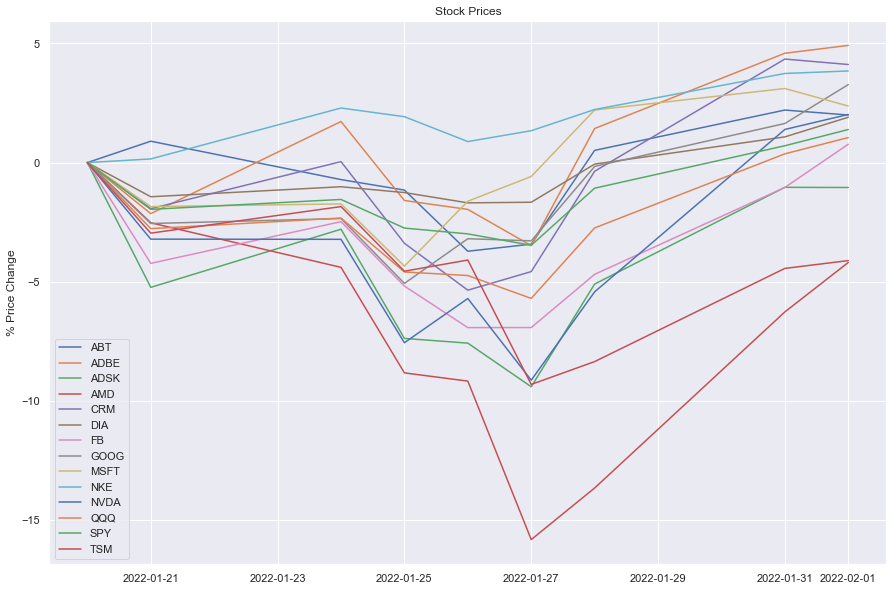

In [14]:
ticker = ['ABT','ADBE','ADSK','AMD','CRM','DIA','FB','GOOG','MSFT','NKE','NVDA','QQQ','SPY','TSM']
comparison_chart(ticker,12)

In [20]:
ticker = ['ABT','ADBE','ADSK','AMD','CRM','FB','GOOGL','MSFT','NKE','NVDA','TSM']
intrinsic_summary(ticker)

,Ticker,Current Stock Price (USD),Intrinsic Value (USD),Buffer %
0,ABT,127.20,139.82,9.03
1,ADBE,535.98,528.60,-1.40
2,ADSK,249.77,338.86,26.29
3,AMD,116.78,119.78,2.50
4,CRM,232.12,138.91,-67.10
5,FB,319.00,870.21,63.34
6,GOOGL,2752.88,8005.22,65.61
7,MSFT,308.76,462.94,33.30
8,NKE,148.22,169.40,12.50
9,NVDA,246.38,171.34,-43.80


## MTT Trading

In [35]:
# Returns candlestick chart with SMA&EMA
def ma_chart(ticker, days):

    end1 = dt.datetime.now()
    end_date = end1.replace(hour=0, minute=0, second=0, microsecond=0)
    start_date = end_date - dt.timedelta(days=1000)
    chart_start = end_date - dt.timedelta(days=days)

    data = web.DataReader(ticker, 'yahoo', start_date, end_date)

    data_low = data[['Low']]
    data_close = data[['Close']]
    sma50 = data_close.rolling(window=50).mean()
    sma100 = data_close.rolling(window=100).mean()
    sma150 = data_close.rolling(window=150).mean()
    sma200 = data_close.rolling(window=200).mean()
    ema20 = data_close.ewm(span=20, adjust=True).mean()
    ema40 = data_close.ewm(span=40, adjust=True).mean()

    prices = pd.DataFrame({'open': data['Open'],
                           'close': data['Close'],
                           'high': data['High'],
                           'low': data['Low']},
                          index=pd.date_range(end=end_date, periods=days, freq="d"))

    # define width of candlestick elements
    width = 1
    width2 = 0.4

    # define up and down prices
    up = prices[prices.close >= prices.open]
    down = prices[prices.close < prices.open]

    fig, ax = plt.subplots(figsize=(20, 9))

    # plot up prices
    ax.bar(up.index, up.close-up.open, width, bottom=up.open, color='green')
    ax.bar(up.index, up.high-up.close, width2, bottom=up.close, color='green')
    ax.bar(up.index, up.low-up.open, width2, bottom=up.open, color='green')

    # plot down prices
    ax.bar(down.index, down.close-down.open,
           width, bottom=down.open, color='red')
    ax.bar(down.index, down.high-down.open,
           width2, bottom=down.open, color='red')
    ax.bar(down.index, down.low-down.close,
           width2, bottom=down.close, color='red')

    #ax.plot(data_close.loc[chart_start:end_date, :].index, data_close.loc[chart_start:end_date], label='Price', color='grey', linewidth=3)
    ax.plot(sma50.loc[chart_start:end_date, :].index,
            sma50.loc[chart_start:end_date], label='50 SMA', color='blue', linewidth=2)
    ax.plot(sma100.loc[chart_start:end_date, :].index,
            sma100.loc[chart_start:end_date], label='100 SMA', color='orange', linewidth=2)
    ax.plot(sma150.loc[chart_start:end_date, :].index,
            sma150.loc[chart_start:end_date], label='150 SMA', color='green', linewidth=2)
    ax.plot(sma200.loc[chart_start:end_date, :].index,
            sma200.loc[chart_start:end_date], label='200 SMA', color='red', linewidth=2)
    ax.plot(ema20.loc[chart_start:end_date, :].index, ema20.loc[chart_start:end_date],
            label='20 EMA', color='red', linestyle='dashed', linewidth=1)
    ax.plot(ema40.loc[chart_start:end_date, :].index, ema40.loc[chart_start:end_date],
            label='40 EMA', color='blue', linestyle='dashed', linewidth=1)

    ax.legend(loc='best')
    ax.set_ylabel('Price in $', fontsize=12)
    ax.set_title(str(ticker) + ' Stock Price Movement', fontsize=15)

In [36]:
# Identifies potential MTT setup
def mtt_setup(ticker):

    data = web.DataReader(ticker, 'yahoo', '2021-01-01',
                          dt.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0))

    data_low = data[['Low']]
    data_close = data[['Close']]
    sma50 = data_close.rolling(window=50).mean()
    sma100 = data_close.rolling(window=100).mean()
    sma150 = data_close.rolling(window=150).mean()
    sma200 = data_close.rolling(window=200).mean()
    ema20 = data_close.ewm(span=20, adjust=True).mean()
    ema40 = data_close.ewm(span=40, adjust=True).mean()

    if ((sma50.iloc[-1] > sma150.iloc[-1]) &
                (ema20.iloc[-1] > ema40.iloc[-1]) &
                ((data_close.iloc[-1] > sma200.iloc[-1]) | (data_close.iloc[-2] > sma200.iloc[-2]) | (data_close.iloc[-3] > sma200.iloc[-3]) | (data_close.iloc[-4] > sma200.iloc[-4])) &
            ((data_low.iloc[-1].item() < sma200.iloc[-1].item()) | (data_low.iloc[-2].item() < sma200.iloc[-2]).item() |
             (data_low.iloc[-3].item() < sma200.iloc[-3].item()) | (data_low.iloc[-4].item() < sma200.iloc[-4].item()))
            ).all():
        x = 'Ok: Dip on Uptrend 200MA'

    elif ((sma50.iloc[-1] > sma150.iloc[-1]) &
          (ema20.iloc[-1] > ema40.iloc[-1]) &
          ((data_close.iloc[-1] > sma150.iloc[-1]) | (data_close.iloc[-2] > sma150.iloc[-2]) | (data_close.iloc[-3] > sma150.iloc[-3]) | (data_close.iloc[-4] > sma150.iloc[-4])) &
          ((data_low.iloc[-1].item() < sma150.iloc[-1].item()) | (data_low.iloc[-2].item() < sma150.iloc[-2]).item() |
           (data_low.iloc[-3].item() < sma150.iloc[-3].item()) | (data_low.iloc[-4].item() < sma150.iloc[-4].item()))
          ).all():
        x = 'Ok: Dip on Uptrend 150MA'

    elif ((sma50.iloc[-1] > sma150.iloc[-1]) &
          (ema20.iloc[-1] > ema40.iloc[-1]) &
          ((data_close.iloc[-1] > sma100.iloc[-1]) | (data_close.iloc[-2] > sma100.iloc[-2]) | (data_close.iloc[-3] > sma100.iloc[-3]) | (data_close.iloc[-4] > sma100.iloc[-4])) &
          ((data_low.iloc[-1].item() < sma100.iloc[-1].item()) | (data_low.iloc[-2].item() < sma100.iloc[-2]).item() |
           (data_low.iloc[-3].item() < sma100.iloc[-3].item()) | (data_low.iloc[-4].item() < sma100.iloc[-4].item()))
          ).all():
        x = 'Ok: Dip on Uptrend 100MA'

    elif ((sma50.iloc[-1] > sma150.iloc[-1]) &
          (ema20.iloc[-1] > ema40.iloc[-1]) &
          ((data_close.iloc[-1] > sma50.iloc[-1]) | (data_close.iloc[-2] > sma50.iloc[-2]) | (data_close.iloc[-3] > sma50.iloc[-3]) | (data_close.iloc[-4] > sma50.iloc[-4])) &
          ((data_low.iloc[-1].item() < sma50.iloc[-1].item()) | (data_low.iloc[-2].item() < sma50.iloc[-2]).item() |
           (data_low.iloc[-3].item() < sma50.iloc[-3].item()) | (data_low.iloc[-4].item() < sma50.iloc[-4].item()))
          ).all():
        x = 'Ok: Dip on Uptrend 50MA'

    elif ((sma50.iloc[-1] > sma150.iloc[-1]) &
          (ema20.iloc[-1] > ema40.iloc[-1]) &
          (data_close.iloc[-1] < sma50.iloc[-1])
          ).all():
        x = 'Ok: Dip on uptrend, hasn\'t found support'

    elif ((sma50.iloc[-1] > sma150.iloc[-1]) &
          (ema20.iloc[-1] < ema40.iloc[-1]) &
          (data_close.iloc[-1] < sma50.iloc[-1])
          ).all():
        x = 'Ok: Only short term downtrend, monitor for reversal'

    else:
        x = 'No setup'

    # ma_chart(ticker,90)

    return x

In [37]:
# Filter with MTT 8 Steps
def mtt_screener(preset):
    
    #1 - Filter with basic finviz screener
    if preset == 'MTT Long':
        filters = {
            'Market Cap.': '+Mid (over $2bln)',
            '20-Day Simple Moving Average': 'SMA20 above SMA50',
            'Price': 'Over $2',
            'Index': 'S&P 500',
            'EPS growthnext 5 years': 'Over 5%',
            '50-Day Simple Moving Average': 'SMA50 above SMA200',
            '200-Day Simple Moving Average': 'Price above SMA200',
            'Average Volume': 'Over 100K',
            'EPS growththis year': 'Over 5%',
            'EPS growthqtr over qtr': 'Over 5%',
            'EPS growthnext year': 'Over 5%',
            'Sales growthqtr over qtr': 'Over 5%'
        }
    elif preset == 'MTT Short':
        filters = {
            'Market Cap.': '+Mid (over $2bln)',
            '20-Day Simple Moving Average': 'SMA20 below SMA50',
            'Price': 'Over $10',
            '50-Day Simple Moving Average': 'SMA50 below SMA200',
            '200-Day Simple Moving Average': 'Price below SMA200',
            'Average Volume': 'Over 100K',
            'EPS growththis year': 'Negative (<0%)',
            'EPS growthnext year': 'Negative (<0%)',
        }
    elif preset == 'VMI Long':
        filters = {
            'Market Cap.': '+Large (over $10bln)',
            'EPS growthpast 5 years': 'Positive (>0%)',
            'Net Profit Margin': 'Positive (>0%)',
            'Price': 'Over $2',
            'Index': 'S&P 500',
            'EPS growthnext 5 years': 'Positive (>0%)',
            'Sales growthpast 5 years': 'Positive (>0%)',
            'Return on Equity': 'Over +10%',
            'Debt/Equity': 'Under 1',
            'Average Volume': 'Over 200K',
            'PEG': 'Under 2',
            'EPS growththis year': 'Positive (>0%)',
            'EPS growthqtr over qtr': 'Positive (>0%)',
            'Gross Margin': 'Positive (>0%)',
            'EPS growthnext year': 'Over 5%',
            'Sales growthqtr over qtr': 'Over 5%',
            'Current Ratio': 'Over 1',
            'Operating Margin': 'Positive (>0%)'
        }
    foverview = Overview()
    foverview.set_filter(filters_dict=filters)
    df_finviz = foverview.screener_view()

    #2 - Filter for performing industries
    perf = Performance()
    industry_perf = perf.screener_view(group='Industry', order='Performance (Week)')
    industry_perf['Perf Week'] = 0.01*industry_perf['Perf Week'].str.strip('%').astype(float)
    great_industry = industry_perf[(industry_perf['Perf Quart'] > 0) & (
        industry_perf['Perf Month'] > 0)]['Name'].reset_index(drop=True)
    df_industry = df_finviz[df_finviz['Industry'].isin(great_industry)].reset_index(drop=True)

    #3 - Filter for stocks with RSI greater than S&P 500
    df_industry['RSI'] = np.nan
    for i in list(range(0, len(df_industry))):
        ticker = df_industry['Ticker'][i]
        df_industry['RSI'][i] = float(finvizfinance(
            ticker).ticker_fundament()['RSI (14)'])
    df_rsi = df_industry[df_industry['RSI'] > float(finvizfinance(
        'SPY').ticker_fundament()['RSI (14)'])].reset_index(drop=True)
    
    return df_rsi

<ipython-input-37-33d9b09b2aeb>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_industry['RSI'][i] = float(finvizfinance(
<ipython-input-38-a22969725038>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mtt['Setup'][i] = mtt_setup(ticker)
C:\Users\steven.s\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Ticker,Company,Sector,Industry,Country,Market Cap,P/E,Price,Change,Volume,RSI,Setup
0,ABC,AmerisourceBergen Corporation,Healthcare,Medical Distribution,USA,2.803000e+10,18.52,136.80,0.0157,840987.0,64.48,No setup
1,DE,Deere & Company,Industrials,Farm & Heavy Construction Machinery,USA,1.158700e+11,19.68,373.79,-0.0058,2050822.0,56.23,Ok: Dip on Uptrend 200MA
2,DVN,Devon Energy Corporation,Energy,Oil & Gas E&P,USA,3.503000e+10,29.81,51.55,-0.0037,9583870.0,64.53,No setup
3,FANG,"Diamondback Energy, Inc.",Energy,Oil & Gas E&P,USA,2.331000e+10,66.8,128.72,0.0006,2296965.0,63.61,No setup
4,OXY,Occidental Petroleum Corporation,Energy,Oil & Gas E&P,USA,3.480000e+10,None,37.57,0.0083,16586346.0,67.94,No setup
5,SLB,Schlumberger Limited,Energy,Oil & Gas Equipment & Services,USA,5.454000e+10,30.13,39.68,0.0211,17880152.0,73.00,No setup


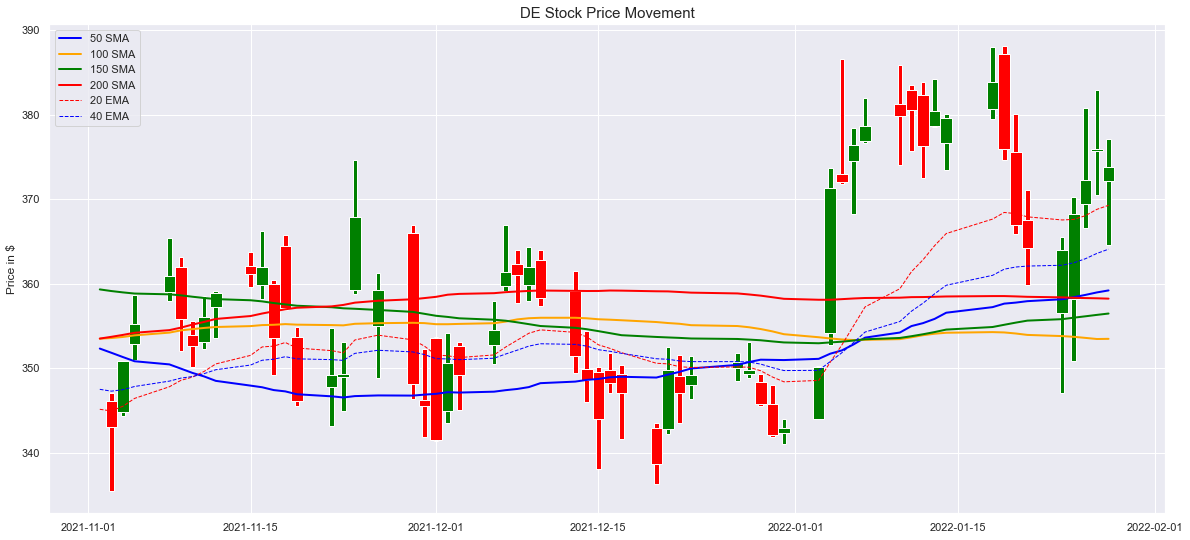

In [38]:
# Identifies MTT setup within screened list
df_mtt = mtt_screener('MTT Long')

df_mtt['Setup'] = np.nan
for i in list(range(0, len(df_mtt))):
    ticker = df_mtt['Ticker'][i]
    df_mtt['Setup'][i] = mtt_setup(ticker)
    if df_mtt['Setup'][i] != 'No setup':
        ma_chart(ticker, 90)

df_mtt